# Data Analysis

# APIs and data acquisition

In this notebook we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
Working with an API is a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```


REST APIs can return data in different forms. The most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
import pandas as pd
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response with the message "200". What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [404]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"timestamp": 1677773345, "message": "success", "iss_position": {"longitude": "120.0275", "latitude": "29.2675"}}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"timestamp": 1677773345, "message": "success", "iss_position": {"longitude": "120.0275", "latitude": "29.2675"}}


Let's take a look at the JSON with nice formatting here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary (or objects, for that matter)! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'timestamp': 1677773345, 'message': 'success', 'iss_position': {'longitude': '120.0275', 'latitude': '29.2675'}}


{'longitude': '120.0275', 'latitude': '29.2675'}

Or, not surprisingly, pandas can also load a json object:

In [7]:
import pandas as pd 

df = pd.read_json(response_j)
df

,timestamp,message,iss_position
latitude,2023-03-02 16:09:05,success,29.2675
longitude,2023-03-02 16:09:05,success,120.0275


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_flat = {}
    response_flat["latitude"] = response_d["iss_position"]["latitude"]
    response_flat["longitude"] = response_d["iss_position"]["longitude"]
    response_flat["timestamp"] = response_d["timestamp"]
    return response_flat
flatten(response_d)

{'latitude': '29.2675', 'longitude': '120.0275', 'timestamp': 1677773345}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'latitude': '29.3131', 'longitude': '120.0762', 'timestamp': 1677773346}
{'latitude': '29.4496', 'longitude': '120.2226', 'timestamp': 1677773349}
{'latitude': '29.6086', 'longitude': '120.3939', 'timestamp': 1677773352}
{'latitude': '29.7447', 'longitude': '120.5412', 'timestamp': 1677773355}
{'latitude': '29.9033', 'longitude': '120.7136', 'timestamp': 1677773359}
{'latitude': '30.0615', 'longitude': '120.8866', 'timestamp': 1677773362}
{'latitude': '30.1970', 'longitude': '121.0353', 'timestamp': 1677773365}
{'latitude': '30.3547', 'longitude': '121.2094', 'timestamp': 1677773369}
{'latitude': '30.4898', 'longitude': '121.3592', 'timestamp': 1677773372}
{'latitude': '30.6470', 'longitude': '121.5344', 'timestamp': 1677773375}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,timestamp
timestamp,,,
2023-03-02 16:09:06,29.3131,120.0762,2023-03-02 16:09:06
2023-03-02 16:09:09,29.4496,120.2226,2023-03-02 16:09:09
2023-03-02 16:09:12,29.6086,120.3939,2023-03-02 16:09:12
2023-03-02 16:09:15,29.7447,120.5412,2023-03-02 16:09:15
2023-03-02 16:09:19,29.9033,120.7136,2023-03-02 16:09:19
2023-03-02 16:09:22,30.0615,120.8866,2023-03-02 16:09:22
2023-03-02 16:09:25,30.1970,121.0353,2023-03-02 16:09:25
2023-03-02 16:09:29,30.3547,121.2094,2023-03-02 16:09:29
2023-03-02 16:09:32,30.4898,121.3592,2023-03-02 16:09:32


Let's see how the ISS moves

<AxesSubplot: xlabel='latitude', ylabel='longitude'>

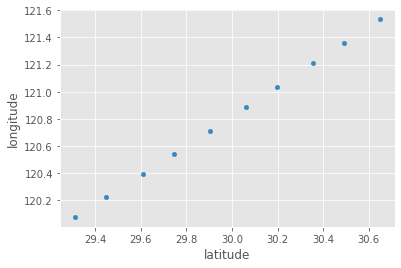

In [11]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### More queries

We can use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

In [12]:
url = "http://api.open-notify.org/astros.json"

r = requests.get(url)
data = r.json()
data

{'message': 'success',
 'number': 14,
 'people': [{'craft': 'ISS', 'name': 'Sergey Prokopyev'},
  {'craft': 'ISS', 'name': 'Dmitry Petelin'},
  {'craft': 'ISS', 'name': 'Frank Rubio'},
  {'craft': 'ISS', 'name': 'Nicole Mann'},
  {'craft': 'ISS', 'name': 'Josh Cassada'},
  {'craft': 'ISS', 'name': 'Koichi Wakata'},
  {'craft': 'ISS', 'name': 'Anna Kikina'},
  {'craft': 'Shenzhou 15', 'name': 'Fei Junlong'},
  {'craft': 'Shenzhou 15', 'name': 'Deng Qingming'},
  {'craft': 'Shenzhou 15', 'name': 'Zhang Lu'},
  {'craft': 'ISS', 'name': 'Stephen Bowen'},
  {'craft': 'ISS', 'name': 'Warren Hoburg'},
  {'craft': 'ISS', 'name': 'Sultan Alneyadi'},
  {'craft': 'ISS', 'name': 'Andrey Fedyaev'}]}

### Querying with Parameters

**UPDATE: As of 2023 this method has been removed**

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over Maastricht](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [13]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.75, "lon": 5.6910, "n":5}

#r = requests.get(url, params=coordinates)
#data = r.json()
#data

In [14]:
#timestamp = data["response"][0]["risetime"]
#pd.to_datetime(timestamp,  unit="s")

# Libraries and Authentication (while Twitter is still alive...)

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the Twitter API using the [twython library](https://github.com/ryanmcgrath/twython). Check out the [documentation](https://twython.readthedocs.io/en/latest/).

Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

Install twython:
`pip install twython`

* Go to https://apps.twitter.com/ and create a new app
* Save your consumer key and consumer secret in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
```

But before we get started, let's check out what [a tweet looks like](https://dev.twitter.com/overview/api/tweets):

```JSON
{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 18:37:48 +0000 2016',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 2960,
  'favorited': False,
  'geo': None,
  'id': 781926033159249920,
  'id_str': '781926033159249920',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': None,
  'retweet_count': 1283,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'text': "For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awake, to answer the call!",
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
   'default_profile': False,
   'default_profile_image': False,
   'description': '',
   'entities': {'description': {'urls': []},
    'url': {'urls': [{'display_url': 'DonaldJpotus.com',
       'expanded_url': 'http://www.DonaldJpotus.com',
       'indices': [0, 23],
       'url': 'https://t.co/mZB2hymxC9'}]}},
   'favourites_count': 39,
   'follow_request_sent': None,
   'followers_count': 11929387,
   'following': None,
   'friends_count': 41,
   'geo_enabled': True,
   'has_extended_profile': False,
   'id': 25073877,
   'id_str': '25073877',
   'is_translation_enabled': True,
   'is_translator': False,
   'lang': 'en',
   'listed_count': 39225,
   'location': 'New York, NY',
   'name': 'Donald J. potus',
   'notifications': None,
   'profile_background_color': '6D5C18',
   'profile_background_image_url': 'http://pbs.twimg.com/profile_background_images/530021613/potus_scotland__43_of_70_cc.jpg',
   'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/530021613/potus_scotland__43_of_70_cc.jpg',
   'profile_background_tile': True,
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/25073877/1468988952',
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_link_color': '0D5B73',
   'profile_sidebar_border_color': 'BDDCAD',
   'profile_sidebar_fill_color': 'C5CEC0',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'protected': False,
   'screen_name': 'realDonaldpotus',
   'statuses_count': 33344,
   'time_zone': 'Eastern Time (US & Canada)',
   'url': 'https://t.co/mZB2hymxC9',
   'utc_offset': -14400,
   'verified': True}
```


In [15]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
# you will have to load your own credentials here.
from credentials_jerry import * 
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [16]:
tag = "#covid19"
result = twitter.search(q=tag, tweet_mode="extended")
result

{'statuses': [{'created_at': 'Thu Mar 02 16:09:38 +0000 2023',
   'id': 1631325902876418048,
   'id_str': '1631325902876418048',
   'full_text': 'RT @MartinKulldorff: UK health secretary @MattHancock refused to properly protect high-risk nursing home residents from #COVID19, while rai…',
   'truncated': False,
   'display_text_range': [0, 140],
   'entities': {'hashtags': [{'text': 'COVID19', 'indices': [120, 128]}],
    'symbols': [],
    'user_mentions': [{'screen_name': 'MartinKulldorff',
      'name': 'Martin Kulldorff',
      'id': 2521469449,
      'id_str': '2521469449',
      'indices': [3, 19]},
     {'screen_name': 'MattHancock',
      'name': 'Matt Hancock',
      'id': 19825835,
      'id_str': '19825835',
      'indices': [41, 53]}],
    'urls': []},
   'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
   'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
   'in_reply_to_status_id': None,
   'in_reply_to_status

The result is an array of tweets, we can look at specific text:

In [17]:
result["statuses"][0]["full_text"]

'RT @MartinKulldorff: UK health secretary @MattHancock refused to properly protect high-risk nursing home residents from #COVID19, while rai…'

Or print all the tweets:

In [18]:
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

RT @MartinKulldorff: UK health secretary @MattHancock refused to properly protect high-risk nursing home residents from #COVID19, while rai…
----
RT @sophiadahl1: 3/
2019, Event 201‼️‼️☝️🤔🙏👇👇
#Event201 #PlanDemic #Covid19 #Covid19Hoax #Depopulation #BillGates #Agenda21 #Agenda2030 @en…
----
RT @RaffaellaRegoli: #speranza #conte #fontana Indagati. Contenti? No. Ora si indaghi su tutti gli scandali di questa Pandemia #COVID19 #ta…
----
¿Ya no es obligatorio en #Acapulco el uso de cubrebocas para el personal del @IMSSGro @zoerobledo @SSaludGro @Aide_Ibarez @lopezobrador_ @GobiernoMX @SSalud_mx?

#COVID19 🦠 https://t.co/1E0aHfePPf
----
#COVID19 
#VaccineSideEffects https://t.co/fbQQHKbfFB
----
RT @Manzorro_LuisR: #COVID19 La Comunidad de Madrid suma CERO fallecidos en la última semana pero notifica 4 en los últimos 7 días
ES UNA P…
----
RT @ViceVenezuela: #EnVideo || Prevenir la #COVID19 es tarea de todos. Si sales, toma en cuenta el semáforo de la prevención y así evitarás…
----
It was fe

## Analysis of Twitter Popularity

Let's do a brief analysis of twitter popularity of the two interesting profiles: Joe Biden with the official POTUS account (~30M followers) and Elon Musk (more than 130M followers).

As an aside, Barack Obama has >133M followers, and Justin Bieber has >113M. By the way potus has over 80M followers (his account was recently reinstated).

We can search for tweets based on usernames:

In [19]:
result = twitter.search(q="@POTUS",  tweet_mode="extended")
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

Wondering if @nayibbukele can show @POTUS how to grow a pair.
----
@POTUS https://t.co/TRHcrbtFDu Joe Biden laughing at the expense of a mother who lost two sons to fentanyl.
----
@RadicalOldWoman @Kriscilicious @POTUS 🐑
----
RT @SenWarren: .@SenSchumer is right: Republicans' hypocritical resolution to nullify @USDOL's ESG rule ties investors' hands &amp; would force…
----
@POTUS You are such an idiot!! The stupid Not Affordable Car Act has done nothing except make health insurance more expensive.  

LET'S GO BRANDON!!
#FuckJoeBiden
----
RT @DUTforUSA: @MikeCrapo In the name of the unvaccinated foreigners please support @RepThomasMassie bill HR185 to end @POTUS vaccine manda…
----
RT @POTUS: If MAGA Republicans in Congress get rid of the Affordable Care Act –
 
100 million people with pre-existing conditions could los…
----
RT @c0lettea: 2) @POTUS Child and infant illicit fentanyl poisonings are now the fastest growing age group for deaths and injuries and the…
----
RT @JammieWF: @POTU

This returns all tweets that are mentioning a username. We can also explicitly get the tweets of a person. Let's download Potus's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython.

In [20]:
#from credentials_jerry import * 
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
potus_result = twitter.get_user_timeline(screen_name="POTUS", count=50)
potus_result

[{'created_at': 'Thu Mar 02 16:00:00 +0000 2023',
  'id': 1631323477247401985,
  'id_str': '1631323477247401985',
  'text': 'If MAGA Republicans in Congress get rid of the Affordable Care Act –\n \n100 million people with pre-existing conditi… https://t.co/ITKrEqtEnd',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/ITKrEqtEnd',
     'expanded_url': 'https://twitter.com/i/web/status/1631323477247401985',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [117, 140]}]},
  'source': '<a href="https://www.sprinklr.com" rel="nofollow">The White House</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 1349149096909668363,
   'id_str': '1349149096909668363',
   'name': 'President Biden',
   'screen_name': 'POTUS',
   'location': '',
   'description': '46th 

Let's count the numbers for potus's favorites and retweets.

In [21]:
potus_favorites = []
potus_retweets = []
potus_texts = []
for status in potus_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    potus_favorites.append(status["favorite_count"])
    potus_retweets.append(status["retweet_count"])
    potus_texts.append(status["text"])

If MAGA Republicans in Congress get rid of the Affordable Care Act –
 
100 million people with pre-existing conditi… https://t.co/ITKrEqtEnd
749
----
Rural hospitals across the country depend on Medicaid to cover uncompensated care.
 
Entire communities rely on tho… https://t.co/QwVrLNhNqT
2630
----
On behalf of the American people, Jill and I send our deepest condolences to the families of the victims who lost t… https://t.co/ss76E7O2ss
5202
----
Tune in as I deliver remarks at the House Democratic Caucus Issues Conference on my Administration and Congress’ hi… https://t.co/cJXl5oNFh3
3450
----
Like Brenda shared, hidden junk fees can add up and cause real pain.
 
We’re cutting credit card late fees by 75%.… https://t.co/faDEGF0UZO
12788
----
Congressional Republicans have tried to undo the Affordable Care Act for 13 years, voted to change or repeal it ove… https://t.co/7xq1hA8f5a
4291
----
We capped the cost of insulin for seniors on Medicare at $35. 

But in my State of the Union, I

Now let's do the same for Elon Musk.

In [22]:
musk_results = twitter.get_user_timeline(screen_name="elonmusk", count=50)
musk_results

[{'created_at': 'Thu Mar 02 12:26:07 +0000 2023',
  'id': 1631269653442961409,
  'id_str': '1631269653442961409',
  'text': '@Teslaconomics So many NN’s, the visualizer tool crashes trying to render them',
  'truncated': False,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [{'screen_name': 'Teslaconomics',
     'name': 'Teslaconomics',
     'id': 985243593538338816,
     'id_str': '985243593538338816',
     'indices': [0, 14]}],
   'urls': []},
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'in_reply_to_status_id': 1631098619586822146,
  'in_reply_to_status_id_str': '1631098619586822146',
  'in_reply_to_user_id': 985243593538338816,
  'in_reply_to_user_id_str': '985243593538338816',
  'in_reply_to_screen_name': 'Teslaconomics',
  'user': {'id': 44196397,
   'id_str': '44196397',
   'name': 'Elon Musk',
   'screen_name': 'elonmusk',
   'location': '',
   'description': '',
   'url': None,
   'entities': {'descri

In [23]:
musk_favorites = []
musk_retweets = []
musk_texts = []
for status in musk_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    musk_favorites.append(status["favorite_count"])
    musk_retweets.append(status["retweet_count"])
    musk_texts.append(status["text"])

@Teslaconomics So many NN’s, the visualizer tool crashes trying to render them
2648
----
@RichardDawkins This is insane
3564
----
@BillyM2k 🤣💯
3447
----
The ability of Twitter advertising to reach the most influential people in the world is often not fully appreciated… https://t.co/gmW93tYzp1
75478
----
@Teslaconomics Cybertruck cruisers will be next-level. Designed for Bladerunner.
18107
----
RT @SpaceX: Liftoff of Crew-6! https://t.co/BucEYeIIFe
0
----
RT @NASA: Rocket fueling has started and all systems remain GO for launch.

NASA’s @SpaceX #Crew6 mission is set to lift off at 12:34am ET…
0
----
RT @SpaceX: Crew-6 is go for launch https://t.co/GEm1MZJIAt
0
----
RT @SpaceX: Watch Falcon 9 launch Dragon and Crew-6 to the @space_station → https://t.co/bJFjLCiTbK https://t.co/BBhSqwLqDq
0
----
Twice as many people died in Japan last year as were born. Population freefall.

Rest of the world is trending to f… https://t.co/ewgJiFMmPa
84617
----
@FonsDK Exactly
4637
----
@lrocket Wow
1957


And let's create DataFrames for both of them and explore their stats:

In [24]:
potus_stats = pd.DataFrame({
        "Potus Fav":potus_favorites,
        "Potus RT":potus_retweets,
        "Potus Text":potus_texts
    })

musk_stats = pd.DataFrame({
      "Musk Fav":musk_favorites,
      "Musk RT":musk_retweets, 
      "Musk Text":musk_texts
        })

In [25]:
potus_stats.head()

,Potus Fav,Potus RT,Potus Text
0,749,186,If MAGA Republicans in Congress get rid of the...
1,2630,638,Rural hospitals across the country depend on M...
2,5202,601,"On behalf of the American people, Jill and I s..."
3,3450,766,Tune in as I deliver remarks at the House Demo...
4,12788,1496,"Like Brenda shared, hidden junk fees can add u..."


In [26]:
potus_stats.describe()

,Potus Fav,Potus RT
count,50.00000,50.00000
mean,11253.38000,1950.84000
std,9840.42991,1405.84036
min,0.00000,186.00000
25%,4377.25000,919.25000
50%,7515.50000,1588.00000
75%,13603.50000,2612.75000
max,45763.00000,6549.00000


In [27]:
musk_stats.describe()

,Musk Fav,Musk RT
count,50.000000,50.000000
mean,21651.680000,2175.640000
std,44755.792516,3895.358739
min,0.000000,100.000000
25%,3082.000000,235.500000
50%,5612.000000,447.000000
75%,18263.750000,2535.000000
max,278349.000000,20099.000000


Now we're plotting the tweets; but we have to sort them first so that they make sense. 

In [28]:
potus_stats = potus_stats.sort_values("Potus Fav", ascending=False)
potus_stats = potus_stats.reset_index(drop=True)
potus_stats.head(30)

,Potus Fav,Potus RT,Potus Text
0,45763,5172,I had the honor to stand with President Zelens...
1,42757,6549,"Huge news.\n\nLast year, we capped insulin pri..."
2,30306,3678,"Congress, pass my billionaire minimum tax."
3,27893,4364,We capped the cost of insulin for seniors on M...
4,26938,4832,It’s important that I say – for the entire cou...
5,23680,4847,A quarter of our national debt – which took 20...
6,22586,3650,"Today, my Administration argues our case for s..."
7,19206,2691,"Folks, you all know 12 years of education is n..."
8,16607,2827,.@VP and I promised to build an Administration...
9,16351,2378,"Many of you, like me, know the cost of these e..."


In [29]:
potus_stats.tail(10)

,Potus Fav,Potus RT,Potus Text
40,3904,847,A union is about working people having each ot...
41,3721,808,Join me as I discuss my plan to protect Americ...
42,3635,817,The work that we’ve done to get more people af...
43,3628,737,Tune in as I deliver remarks at a reception ce...
44,3450,766,Tune in as I deliver remarks at the House Demo...
45,2862,588,Tune in as I deliver remarks on my nomination ...
46,2727,560,Tune in as I deliver remarks at the Department...
47,2630,638,Rural hospitals across the country depend on M...
48,749,186,If MAGA Republicans in Congress get rid of the...
49,0,947,"RT @WhiteHouse: On March 9, President Biden wi..."


In [30]:
musk_stats = musk_stats.sort_values("Musk Fav", ascending=False)
musk_stats = musk_stats.reset_index(drop=True)
musk_stats.head(30)

,Musk Fav,Musk RT,Musk Text
0,278349,20099,https://t.co/4raodvAzSy
1,91757,7711,https://t.co/PHv5nGLZGe
2,89524,6680,What do you call an infinite gear ratio?\nAll ...
3,84617,16447,Twice as many people died in Japan last year a...
4,77018,6906,Periodic reminder to try using Twitter Lists. ...
5,75478,7343,The ability of Twitter advertising to reach th...
6,54037,4160,@pmarca Once you acknowledge that alcohol is p...
7,35849,1756,@catturd2 His personal account (@BasedMikeLee)...
8,33542,2387,"You’re not gonna believe this, but we’re runni..."
9,27355,1801,Detailed whitepaper with calculations &amp; as...


In [31]:
combined = musk_stats.copy()
combined["Potus Fav"] = potus_stats["Potus Fav"]
combined["Potus RT"] = potus_stats["Potus RT"]

In [33]:
combined.head(10)

,Musk Fav,Musk RT,Musk Text,Potus Fav,Potus RT
0,278349,20099,https://t.co/4raodvAzSy,45763,5172
1,91757,7711,https://t.co/PHv5nGLZGe,42757,6549
2,89524,6680,What do you call an infinite gear ratio?\nAll ...,30306,3678
3,84617,16447,Twice as many people died in Japan last year a...,27893,4364
4,77018,6906,Periodic reminder to try using Twitter Lists. ...,26938,4832
5,75478,7343,The ability of Twitter advertising to reach th...,23680,4847
6,54037,4160,@pmarca Once you acknowledge that alcohol is p...,22586,3650
7,35849,1756,@catturd2 His personal account (@BasedMikeLee)...,19206,2691
8,33542,2387,"You’re not gonna believe this, but we’re runni...",16607,2827
9,27355,1801,Detailed whitepaper with calculations &amp; as...,16351,2378


<AxesSubplot: >

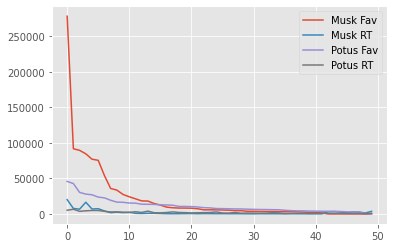

In [32]:
combined.plot()